# Laboratorio 5 - Data Science Universidad del Valle de Guatemala
María Marta Ramírez Gil 21342
Gustavo Andrés Gonzalez 21438 

------------------------------------------------------------------------------

Importaciones  

In [1]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import emoji
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np

cargar la data

In [2]:
data = pd.read_csv('train.csv')

# EDA

In [3]:
# Mostrar las primeras filas del dataset
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Chequear si hay valores nulos
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
# Eliminar valores nulos
data = data.dropna()

# Chequear si quedan valores nulos
data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [6]:
# Estadiscas descriptivas del dataset
print("info del dataset:")
data.info()

info del dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5080 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5080 non-null   int64 
 1   keyword   5080 non-null   object
 2   location  5080 non-null   object
 3   text      5080 non-null   object
 4   target    5080 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 238.1+ KB


In [7]:
# Cantidad de columnas
print("Cantidad de columnas:")
print(len(data.columns))
print()

print("Nombre de las columnas:")
print(data.columns)
print()

# Cantidad de filas
print("Cantidad de filas:")
print(data.shape)
print()

# Tipos de datos por columna
print("Tipos de datos por columna:")
data.dtypes

Cantidad de columnas:
5

Nombre de las columnas:
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

Cantidad de filas:
(5080, 5)

Tipos de datos por columna:


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Limpiar y Preprocesamiento de la data

In [8]:
data_copy = data.copy()  # Copia del dataset para mejor manejo de los datos

# Convertir texto a minúsculas
data_copy['text'] = data_copy['text'].str.lower()

# Quitar URL's
data_copy['text'] = data_copy['text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

# Quitar puntuación
data_copy['text'] = data_copy['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Quitar stopwords
stop = set(stopwords.words('english'))
data_copy['text'] = data_copy['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# Quitar números
data_copy['text'] = data_copy['text'].apply(lambda x: re.sub(r'\d+', '', x))

# Eliminar todas las posibles variantes de 'û'
data_copy['text'] = data_copy['text'].apply(lambda x: re.sub(r'[ûÛ]', '', x))

# Quitar emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

# Aplicar la función a la columna de texto
data_copy['text'] = data_copy['text'].apply(remove_emojis)

# Mostrar las primeras filas del dataset
data_copy.head()

# Guardar el dataset limpio
data_copy.to_csv('train_clean.csv', index=False)    

Se limpian los datos eliminando URLs, puntuación, stopwords, números y emojis.

## Word Frequency Analysis

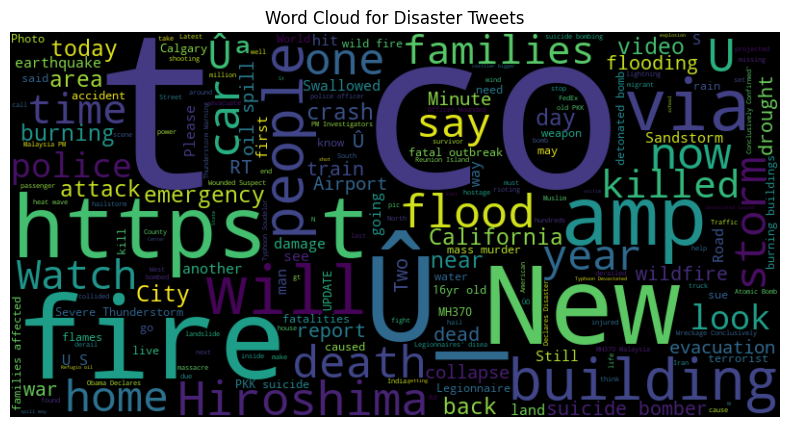

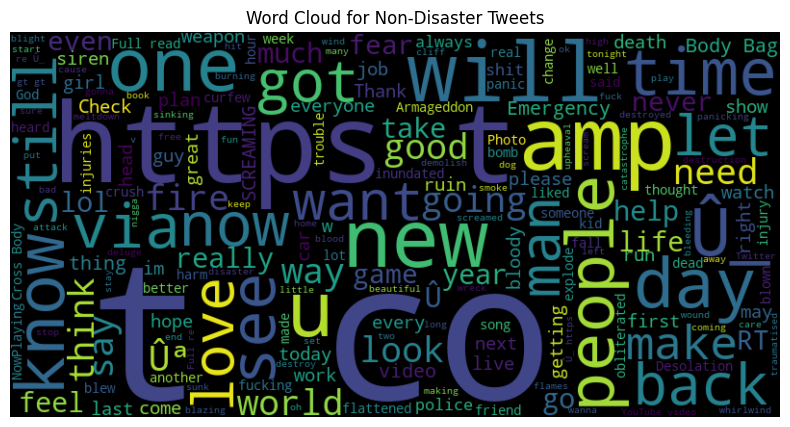

In [9]:
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

# Cantidad de tweets de desastres
disaster_words = ' '.join(disaster_tweets['text'])
non_disaster_words = ' '.join(non_disaster_tweets['text'])

# Generar wordclouds
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400).generate(disaster_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Disaster Tweets')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400).generate(non_disaster_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Non-Disaster Tweets')
plt.axis('off')
plt.show()

#### Palabras clave para un mejor modelo de clasificación:

Palabras como `fire`, `flood`, `die`, `emergency`, `killed`, `storm`, `suicide` son indicativas de desastres y deben ser consideradas como clave en el modelo.

Se observa que hay un problema con el caracter û

### Diagramas

In [10]:
# Generar bigramas y trigramas con TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=5000)

# Vectorización del texto con bigramas y trigramas
X = vectorizer.fit_transform(data_copy['text'])

# Definir las etiquetas
y = data_copy['target']

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de clasificación, en este caso, Logistic Regression
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Mostrar algunos bigramas y trigramas más comunes
feature_names = vectorizer.get_feature_names_out()
print("Algunos bigramas y trigramas más comunes:")
for i in range(10):
    print(feature_names[i])

Accuracy: 0.7254
              precision    recall  f1-score   support

           0       0.69      0.93      0.80       580
           1       0.83      0.45      0.58       436

    accuracy                           0.73      1016
   macro avg       0.76      0.69      0.69      1016
weighted avg       0.75      0.73      0.70      1016

Algunos bigramas y trigramas más comunes:
aba woman
aba woman delivers
abandoned aircraft
abandoned aircraft mma
abbswinston zionist
abbswinston zionist terrorist
abc news
ablaze amp
ablaze california
ablaze california alone


Los bigramas como "abandoned aircraft" y "ablaze california" son claros indicadores de desastres, mientras que otros como "abc news" pueden ser menos útiles. Refinar el preprocesamiento para eliminar palabras irrelevantes y utilizar estos n-gramas como características en modelos de clasificación podría mejorar la precisión en la identificación de tweets sobre desastres.

## Entrenamiento del Modelo 1

In [11]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

# Crear el modelo de clasificación de texto con Naive Bayes
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

## Evaluacion del Modelo

Accuracy: 0.7992125984251969
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       580
           1       0.87      0.63      0.73       436

    accuracy                           0.80      1016
   macro avg       0.82      0.78      0.78      1016
weighted avg       0.81      0.80      0.79      1016



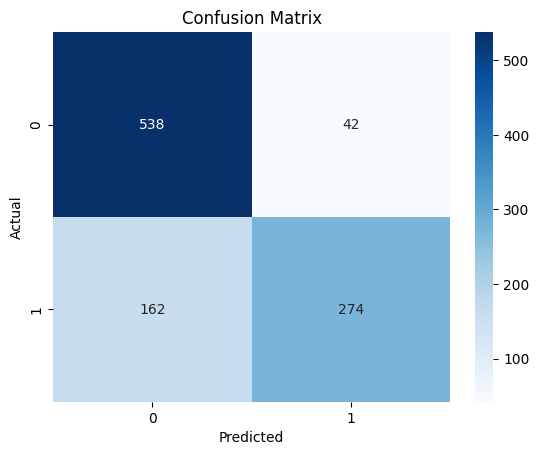

In [12]:
# Predecir los datos de prueba
y_pred = model.predict(X_test)

# Métricas de evaluación
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Funcion para la clasificacion de tweets

In [13]:
def classify_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop])
    text = re.sub(r'\d+', '', text)
    return model.predict([text])[0]

### Uso Modelo 1

In [14]:
tweet = "Forest fire near La Ronge Sask. Canada"
print("Tweet:", tweet)
print("Classification:", "Disaster" if classify_tweet(tweet) == 1 else "Not a Disaster")

Tweet: Forest fire near La Ronge Sask. Canada
Classification: Disaster


## Modelo 2

In [15]:
# Vectorización del texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data_copy['text'])

# Definir las etiquetas (0: Not Disaster, 1: Disaster)
y = data_copy['target']

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Support Vector Machine': SVC(kernel='linear')
}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("\n" + "="*60 + "\n")

# Uso de Logistic Regression para predecir un tweet
def classify_tweetRL(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop])
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[ûÛ]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = vectorizer.transform([text])
    return models['Logistic Regression'].predict(text)[0]

# Uso de Naive Bayes para predecir un tweet
def classify_tweetNB(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop])
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[ûÛ]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = vectorizer.transform([text])
    return models['Naive Bayes'].predict(text)[0]

# Uso de Random Forest para predecir un tweet
def classify_tweetRF(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop])
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[ûÛ]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = vectorizer.transform([text])
    return models['Random Forest'].predict(text)[0] 

# Uso de Support Vector Machine para predecir un tweet
def classify_tweetSVM(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop])
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[ûÛ]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = vectorizer.transform([text])
    return models['Support Vector Machine'].predict(text)[0]

Model: Logistic Regression
Accuracy: 0.8012
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       580
           1       0.83      0.67      0.74       436

    accuracy                           0.80      1016
   macro avg       0.81      0.78      0.79      1016
weighted avg       0.81      0.80      0.80      1016



Model: Naive Bayes
Accuracy: 0.8051
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       580
           1       0.83      0.69      0.75       436

    accuracy                           0.81      1016
   macro avg       0.81      0.79      0.80      1016
weighted avg       0.81      0.81      0.80      1016



Model: Random Forest
Accuracy: 0.7726
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       580
           1       0.78      0.65      0.71       436

    accuracy                           0.77      1016
   mac

Uso

In [16]:
tweet = "Forest fire near La Ronge Sask. Canada"

# Tweet de prueba Linear Regression
print("Tweet:", tweet)
print("Classification:", "Disaster" if classify_tweetRL(tweet) == 1 else "Not a Disaster")

# Tweet de prueba Naive Bayes
print("Tweet:", tweet)
print("Classification:", "Disaster" if classify_tweetNB(tweet) == 1 else "Not a Disaster")

# Tweet de prueba Random Forest
print("Tweet:", tweet)
print("Classification:", "Disaster" if classify_tweetRF(tweet) == 1 else "Not a Disaster")

# Tweet de prueba Support Vector Machine
print("Tweet:", tweet)
print("Classification:", "Disaster" if classify_tweetSVM(tweet) == 1 else "Not a Disaster")


Tweet: Forest fire near La Ronge Sask. Canada
Classification: Disaster
Tweet: Forest fire near La Ronge Sask. Canada
Classification: Disaster
Tweet: Forest fire near La Ronge Sask. Canada
Classification: Disaster
Tweet: Forest fire near La Ronge Sask. Canada
Classification: Disaster


Los modelos fueron puestos a prueba. Todos los modelos tienen un rendimiento muy parecido y similar. Por lo que podemos deicir que la mejora de la precisión no recide en el modelo que se use, si no que en el preprocesamiento de datos y limpieza previa que se realiza.

### Determinar si un tweet es positivo, negativo o neutral.

In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Inicializar VADER
analyzer = SentimentIntensityAnalyzer()

# Función para obtener el sentimiento del tweet
def sentiment_score(tweet):
    score = analyzer.polarity_scores(tweet)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Aplicar la función al dataset
data_copy['sentiment'] = data_copy['text'].apply(sentiment_score)

# Mostrar los primeros tweets con sus sentimientos
data_copy[['text', 'sentiment']].head()


,text,sentiment
31,bbcmtd wholesale markets ablaze,Neutral
32,always try bring heavy metal rt,Neutral
33,africanbaze breaking newsnigeria flag set abla...,Neutral
34,crying set ablaze,Negative
35,plus side look sky last night ablaze,Neutral


## 10 tweets mas negativos

In [18]:
# Función para extraer el puntaje de negatividad
def negative_score(tweet):
    return analyzer.polarity_scores(tweet)['neg']

# Añadir la columna de puntaje de negatividad
data_copy['negative_score'] = data_copy['text'].apply(negative_score)

# Obtener los 10 tweets más negativos
top_negative_tweets = data_copy.sort_values(by='negative_score', ascending=False).head(10)
print("Top 10 tweets más negativos:")
print(top_negative_tweets[['text', 'negative_score', 'sentiment']])

Top 10 tweets más negativos:
                        text  negative_score sentiment
481           anxiety attack           1.000  Negative
3670                fatality           1.000  Negative
3717              worst fear           1.000  Negative
3696                fatality           1.000  Negative
3674                fatality           1.000  Negative
5988                 screams           1.000  Negative
6015                 screams           1.000  Negative
3667                fatality           1.000  Negative
5184             obliterated           1.000  Negative
2019  real shit damage bitch           0.914  Negative


## 10 Tweets mas positivos

In [19]:
# Función para extraer el puntaje de positividad
def positive_score(tweet):
    return analyzer.polarity_scores(tweet)['pos']

# Añadir la columna de puntaje de positividad
data_copy['positive_score'] = data_copy['text'].apply(positive_score)

# Obtener los 10 tweets más positivos
top_positive_tweets = data_copy.sort_values(by='positive_score', ascending=False).head(10)
print("Top 10 tweets más positivos:")
print(top_positive_tweets[['text', 'positive_score', 'sentiment']])

Top 10 tweets más positivos:
                                        text  positive_score sentiment
6140                   super sweet beautiful           1.000  Positive
6155           save save save heavydirtysoul           0.906  Positive
645                         shayoly yes love           0.873  Positive
6536              taaylordarr thank survived           0.853  Positive
4758               benjidevos thanks thanks            0.853  Positive
4931            real heroes rip brave hearts           0.846  Positive
6780                     dont forget tragedy           0.838  Positive
1567  ok peace hope fall cliff along dignity           0.790  Positive
5570                   want rainstorm please           0.783  Positive
1856     love love love remember first crush           0.778  Positive


## Comparar el sentimiento entre las categorías de tweets de desastres reales y no reales

In [20]:
# Asumiendo que ya tenemos una columna 'category' que identifica si un tweet es sobre un desastre real o no
real_disasters = data_copy[data_copy['target'] == 1]
non_disasters = data_copy[data_copy['target'] == 0]

# Comparar el promedio de negatividad
avg_negative_real = real_disasters['negative_score'].mean()
avg_negative_non_real = non_disasters['negative_score'].mean()

print(f"Negatividad promedio - Desastres reales: {avg_negative_real}")
print(f"Negatividad promedio - No desastres: {avg_negative_non_real}")

Negatividad promedio - Desastres reales: 0.231577868852459
Negatividad promedio - No desastres: 0.18557593619972262


## Creacion de la variable de negativadad

In [23]:
# Añadir la columna de "negatividad"
data_copy['negativity'] = data_copy['negative_score']

# Entrenar el modelo de clasificacion nuevamente, incluyendo la columna 'negativity'
X = data_copy[['text', 'negativity']]  # Incluyendo la nueva variable
y = data_copy['target']

# Vectorizar el texto (puedes usar CountVectorizer o TfidfVectorizer)
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(data_copy['text'])

# Añadir la variable de negatividad a la matriz de características

X_combined = np.hstack((X_tfidf.toarray(), data_copy[['negativity']].values))

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = LogisticRegression()
model.fit(X_train, y_train)

# Predecir y evaluar
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Comparar el rendimiento del modelo con y sin la variable de negatividad


              precision    recall  f1-score   support

           0       0.78      0.86      0.82       580
           1       0.78      0.67      0.72       436

    accuracy                           0.78      1016
   macro avg       0.78      0.76      0.77      1016
weighted avg       0.78      0.78      0.77      1016



## Discusion comparando ambos

### Comparacion:
- Exactitud: Sin la variable de negatividad, el modelo tiene una mejor exactitud (0.80 frente a 0.78).
- F1-score: La puntuación F1 para la clase 1 (desastre) es levemente mejor cuando no se incluye la variable de negatividad (0.73 frente a 0.72).
- Recall para clase 1: El recall para la clase de desastres es más alto sin la variable de negatividad (0.67 con la variable vs 0.63 sin ella).

### Conclusion:
La inclusión de la variable "negatividad" parece que no hace mejorar el rendimiento del modelo significativamente. De hecho, sin esta variable, el modelo logra ser más preciso generalmente y un mejor equilibrio entre la precisión y el rrecall, particularmente para la clase 1 (desastre). Aunque entendemos que agregar una variable como la 'negatividad' pordria ser util, en este caso no se observa una mejora clara en el rendimiento del modelo.